# Computer Vision for Media

## Or training a deep learning model to DJ for me with the wave of a hand

---

### Imports and Downloads

In [2]:
import os
import warnings
import cv2
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
import time
import tensorflow
import tensorflow.keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from google.cloud import storage
import pickle

%matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

In [35]:
from tensorflow.keras.models import model_from_json

### Google Cloud Storage Downloads

In [5]:
client = storage.Client()
print("Client created using default project: {}".format(client.project))

Client created using default project: hand-vision


In [6]:
buckets = client.list_buckets()

print("Buckets in {}:".format(client.project))
for item in buckets:
    print("\t" + item.name)

Buckets in hand-vision:
	hand-vision-bucket


In [7]:
bucket = client.get_bucket('hand-vision-bucket')

In [8]:
# Get bucket metadata

print("Bucket name: {}".format(bucket.name))
print("Bucket location: {}".format(bucket.location))
print("Bucket storage class: {}".format(bucket.storage_class))

Bucket name: hand-vision-bucket
Bucket location: US
Bucket storage class: STANDARD


In [6]:
# Download raw images

bucket_name = 'hand-vision-bucket'
prefix = 'capture/'
dl_dir = 'capture_local/'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    filename = blob.name.replace('capture/', '') 
    blob.download_to_filename(dl_dir + filename)  # Download

### Getting a visual

In [3]:
pic = Image.open('five_gestures/00/07_ok/frame_00_07_0010.png')

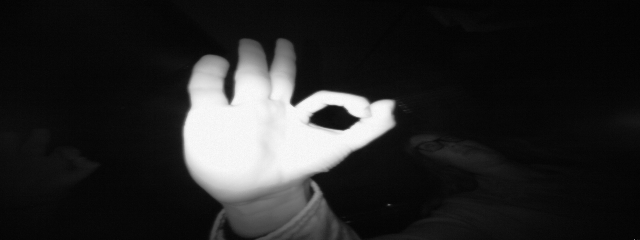

In [4]:
pic

# First Approach: Original Kaggle Dataset
---

### Transforming the images into array format

In [18]:
gestures_map = {3: 0,
                2: 1,
                7: 2,
                1: 3,
                }
X_data = []
y_data = []

root_dir = os.fsencode('five_gestures/')

start_time = time.time()

for directory, subdirectories, files in os.walk(root_dir): # Loop over subject directories, gesture subdirectories and image files
    for file in files:
        if not file.startswith(b'.'): #Skip any hidden files
            gesture_name = int(file.decode('utf8')[10:11]) # Get gesture name
            if gesture_name in [1, 2, 3, 7]: # Ensure we have the right signs
                path = os.path.join(directory, file).decode('utf8') # Get string version of file path
                y_data.append(gestures_map[gesture_name]) # Get
                frame = cv2.imread(path, cv2.IMREAD_COLOR) # Loads an image from a file & convert image to 3-channel BGR color image
                frame = cv2.flip(frame, 1) # Flipping image on y-axis to recognize right-hand
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = cv2.resize(frame, (224, 224))
                frame = np.array(frame)
                X_data.append(frame) # appending final image array to our list

            else:
                continue

end_time = time.time()
print("Total time taken this loop: ", end_time - start_time)

Total time taken this loop:  22.29596447944641


In [1]:
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32') # Converting image array from dtype uint8 to float32
    X_data = np.stack((X_data,)*3, axis=-1) # because images are B&W, NumPy arrays have only one channel, not three
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data) #Converts a class vector to a binary class matrix for use with categorical crossentropy
    return X_data, y_data

In [19]:
X_data, y_data = process_data(X_data, y_data)

### Visualizing transformed data

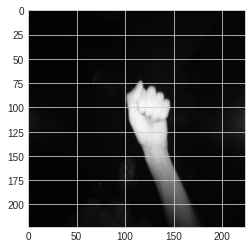

In [191]:
plt.imshow(X_data[320])

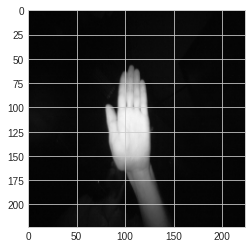

In [192]:
plt.imshow(X_data[455])

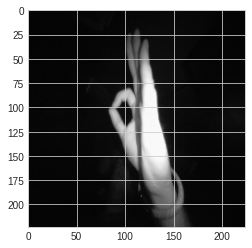

In [195]:
plt.imshow(X_data[6300])

### Training the model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

In [21]:
filepath = 'saved_models/model0_original.hdf5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', # Target metric
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [22]:
imageSize = 224

vgg_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(imageSize, imageSize, 3)) # Image is 224x224 pixels and 3 channels

base_model = vgg_base #topless

# Add top layer
x = base_model.output # research further
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(4, activation='softmax')(x) # research further

model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

#Adam optimiser to reach to the global minima while training out model.
# If I am stuck in local minima while training then the adam optimiser 
# will help us to get out of local minima and reach global minima.

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs = 15,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose = 1,
          callbacks=[early_stopping, model_checkpoint])

Train on 6400 samples, validate on 6400 samples
Epoch 1/15
6400/6400 [==============================] - 468s 73ms/sample - loss: 0.2598 - accuracy: 0.9006 - val_loss: 6.5746e-05 - val_accuracy: 1.0000
Epoch 2/15
6400/6400 [==============================] - 465s 73ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.8596e-05 - val_accuracy: 1.0000
Epoch 3/15
6400/6400 [==============================] - 462s 72ms/sample - loss: 3.3297e-04 - accuracy: 1.0000 - val_loss: 1.7332e-06 - val_accuracy: 1.0000
Epoch 4/15
6400/6400 [==============================] - 457s 71ms/sample - loss: 1.8606e-04 - accuracy: 1.0000 - val_loss: 8.9806e-07 - val_accuracy: 1.0000
Epoch 5/15
6400/6400 [==============================] - 456s 71ms/sample - loss: 1.2673e-04 - accuracy: 1.0000 - val_loss: 1.2226e-06 - val_accuracy: 1.0000
Epoch 6/15
6400/6400 [==============================] - 457s 71ms/sample - loss: 1.8826e-04 - accuracy: 1.0000 - val_loss: 1.4500e-07 - val_accuracy: 1.0000
Epoch 7/15
6400/64

### Classification Metrics

In [204]:
get_classification_metrics(X_test, y_test)

[[400   0   0   0]
 [  0 401   0   0]
 [  0   0 400   0]
 [  0   0   0 400]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       401
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1601
   macro avg       1.00      1.00      1.00      1601
weighted avg       1.00      1.00      1.00      1601



Excellent scores, but we must account for the fact that are webcam images will not be similar to these. Let's apply some additional transformations on the images to improve the model's predictions on dissimilar images.

# Second Approach: Transformed Kaggle Dataset
---

### New Image Transformations

In [6]:
gestures_map = {3: 0,
                2: 1,
                7: 2,
                1: 3,
                }
X_data = []
y_data = []

root_dir = os.fsencode('five_gestures/')

start_time = time.time()

for directory, subdirectories, files in os.walk(root_dir): # Loop over subject directories, gesture subdirectories and image files
    print('Starting directory {} in subdirectory {}'.format(directory, subdirectories))
    for file in files:
        if not file.startswith(b'.'): #Skip any hidden files
            gesture_name = int(file.decode('utf8')[10:11]) # Get gesture name
            if gesture_name in [1, 2, 3, 7]: # Ensure we have the right signs
                path = os.path.join(directory, file).decode('utf8') # Get string version of file path
                y_data.append(gestures_map[gesture_name]) # Get
                img = cv2.imread(path, cv2.IMREAD_COLOR) # Loads an image from a file & convert image to 3-channel BGR color image
                img = cv2.flip(img, 1) # Flipping image on y-axis to recognize right-hand
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Retaining 3-channels while changing back to grayscale
                blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
                ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Image pixel assigned
                # one of two values (black or white) based on whether it is above or below (right or left of) the
                # threshould value. After gaussian filtering, our image's histogram will exhibit two peaks (bimodal).
                # Instead of setting an arbitrary threshold value ourselves, Otsu's thresholding 'automatically calculates
                # a threshold value from image histogram for a bimodal image'. 'thresh' is our thresholded image.
                thresh = cv2.resize(thresh, (224, 224)) #resizing image width and height to expectations of VGG16
                thresh = np.array(thresh) # converting image to array for modeling compatibility
                X_data.append(thresh) # appending final image array to our list

            else:
                continue

end_time = time.time()
print("Total time taken this loop: ", end_time - start_time)

Starting directory b'five_gestures/' in subdirectory [b'03', b'01', b'00', b'05', b'07', b'04', b'02', b'08', b'06', b'09']
Starting directory b'five_gestures/03' in subdirectory [b'02_l', b'03_fist', b'01_palm', b'07_ok']
Starting directory b'five_gestures/03/02_l' in subdirectory []
Starting directory b'five_gestures/03/03_fist' in subdirectory []
Starting directory b'five_gestures/03/01_palm' in subdirectory []
Starting directory b'five_gestures/03/07_ok' in subdirectory []
Starting directory b'five_gestures/01' in subdirectory [b'02_l', b'03_fist', b'01_palm', b'07_ok']
Starting directory b'five_gestures/01/02_l' in subdirectory []
Starting directory b'five_gestures/01/03_fist' in subdirectory []
Starting directory b'five_gestures/01/01_palm' in subdirectory []
Starting directory b'five_gestures/01/07_ok' in subdirectory []
Starting directory b'five_gestures/00' in subdirectory [b'02_l', b'03_fist', b'01_palm', b'07_ok']
Starting directory b'five_gestures/00/02_l' in subdirectory [

In [17]:
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32') # Converting image array from dtype uint8 to float32
    X_data = np.stack((X_data,)*3, axis=-1) # because images are B&W, NumPy arrays have only one channel, not three
    # VGG-16 requires three channels, which np.stack helps us do
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data) #Converts a class vector to a binary class matrix for use with categorical crossentropy
    return X_data, y_data

In [8]:
X_data, y_data = process_data(X_data, y_data)

### Visualizing the transformed images

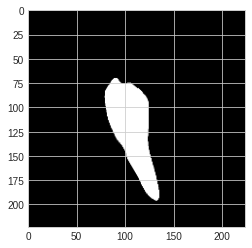

In [235]:
plt.imshow(X_data[250])

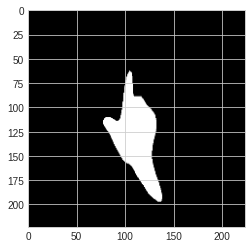

In [238]:
plt.imshow(X_data[100])

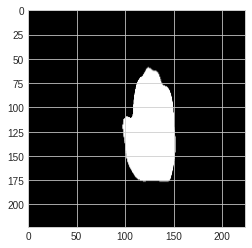

In [237]:
plt.imshow(X_data[1200])

### Training our model on the new data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

In [26]:
filepath = 'saved_models/model2.hdf5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', # Target metric
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [27]:
imageSize = 224

vgg_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(imageSize, imageSize, 3)) # Image is 224x224 pixels and 3 channels

#Adam optimiser to reach to the global minima while training out model.
# If I am stuck in local minima while training then the adam optimiser 
# will help us to get out of local minima and reach global minima.

optimizer1 = optimizers.Adam()

base_model = vgg_base #topless

# Add top layer
x = base_model.output # research further
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(4, activation='softmax')(x) # research further

model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False
    
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc',
                                                patience=3,
                                                verbose=1)]

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs = 1,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose =1,
          callbacks=[early_stopping, model_checkpoint])

Train on 6400 samples, validate on 6400 samples
Epoch 1/1
6400/6400 [==============================] - 546s 85ms/step - loss: 0.2734 - accuracy: 0.8906 - val_loss: 6.9058e-04 - val_accuracy: 0.9997


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


### Classification Metrics

In [140]:
pred = model.predict(X_test)

In [141]:
pred = np.argmax(pred, axis=1)

In [16]:
def get_classification_metrics(X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))

In [16]:
get_classification_metrics(X_data, y_data)

[[2000    0    0    0]
 [   0 2000    0    0]
 [   0    0 2000    0]
 [   0    0    0 2000]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000
           2       1.00      1.00      1.00      2000
           3       1.00      1.00      1.00      2000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



It is expected that the model would performed well on the entire dataset, since it has seen 80% of it. Let's look it how it performs exclusively on the the test set.

In [17]:
get_classification_metrics(X_test, y_test)

[[400   0   0   0]
 [  0 400   0   0]
 [  0   0 400   0]
 [  0   0   0 400]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



Perfect performance. However, all of these images belong to a single dataset and had the same look and style. Let's see how it performs on an image from a different source - my webcam.

## Custom Model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

In [9]:
filepath = 'saved_models/model1_hybrid.hdf5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', # Target metric
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=50,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose=1,
          callbacks = [early_stopping, model_checkpoint])

Train on 6400 samples, validate on 6400 samples
Epoch 1/50
6400/6400 [==============================] - 64s 10ms/step - loss: 0.2766 - accuracy: 0.8966 - val_loss: 0.0098 - val_accuracy: 0.9978
Epoch 2/50


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6400/6400 [==============================] - 63s 10ms/step - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.0058 - val_accuracy: 0.9977
Epoch 3/50
6400/6400 [==============================] - 56s 9ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 6.7788e-04 - val_accuracy: 0.9997
Epoch 4/50
6400/6400 [==============================] - 58s 9ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 6.4270e-04 - val_accuracy: 0.9998
Epoch 5/50
6400/6400 [==============================] - 59s 9ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 6.3657e-04 - val_accuracy: 0.9998
Epoch 6/50
6400/6400 [==============================] - 58s 9ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 1.1683e-04 - val_accuracy: 1.0000
Epoch 7/50
6400/6400 [==============================] - 58s 9ms/step - loss: 7.5743e-04 - accuracy: 0.9998 - val_loss: 1.8376e-05 - val_accuracy: 1.0000
Epoch 8/50
6400/6400 [==============================] - 56s 9ms/step - loss: 8.5717e-05 - accuracy: 1.0000 - val_los

In [3]:
model = load_model('saved_models/model1_hybrid.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:811: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(loss, collections.Mapping):
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:348: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


In [10]:
get_classification_metrics(X_test, y_test)

[[400   0   0   0]
 [  0 401   0   0]
 [  0   0 400   0]
 [  0   0   0 400]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       401
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1601
   macro avg       1.00      1.00      1.00      1601
weighted avg       1.00      1.00      1.00      1601



# Third Approach: Custom Dataset

### Transforming dataset into array

In [23]:
gestures = {'L_': 'L',
           'fi': 'Fist',
           'C_': 'C',
           'ok': 'Okay',
           'pe': 'Peace',
           'pa': 'Palm'
            }

gestures_map = {'Fist' : 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Peace': 4
                }

In [24]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

In [25]:
def walk_file_tree(relative_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [26]:
relative_path = 'silhouettes'
rgb = False

# # This method processes the data
X_data_sil, y_data_sil = walk_file_tree(relative_path)

In [27]:
print(f'X_data shape: {X_data_sil.shape}')
print(f'y_data shape: {y_data_sil.shape}')

X_data shape: (2748, 224, 224, 3)
y_data shape: (2748, 5)


### Visualization

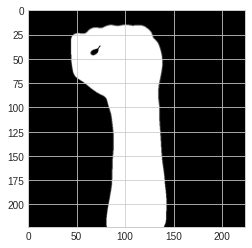

In [22]:
plt.imshow(X_data_sil[0])

### Training our model with the new data

The model’s performance exceeded my expectations. It classified nearly every gesture in the test set correctly, ending up with a 98% F1 score, as well as 98% precision and accuracy scores. This was great news!

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_data_sil, y_data_sil, test_size = 0.2, random_state=42, stratify=y_data_sil)

### Model 1

In [32]:
filepath = 'saved_models/model_sil_weights.h5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True, save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy', # Target metric
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [33]:
imageSize = 224

vgg_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(imageSize, imageSize, 3)) # Image is 224x224 pixels and 3 channels

#Adam optimiser to reach to the global minima while training out model.
# If I am stuck in local minima while training then the adam optimiser 
# will help us to get out of local minima and reach global minima.

base_model = vgg_base #topless

# Add top layer
x = base_model.output # research further
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(5, activation='softmax')(x) # research further

model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs = 20,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose =1,
          callbacks=[early_stopping, model_checkpoint])

Train on 2198 samples, validate on 2198 samples
Epoch 1/20
2198/2198 [==============================] - 155s 71ms/sample - loss: 1.1313 - accuracy: 0.5537 - val_loss: 0.1998 - val_accuracy: 0.9509
Epoch 2/20
2198/2198 [==============================] - 154s 70ms/sample - loss: 0.1581 - accuracy: 0.9513 - val_loss: 0.0337 - val_accuracy: 0.9932
Epoch 3/20
2198/2198 [==============================] - 154s 70ms/sample - loss: 0.0788 - accuracy: 0.9736 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 4/20
2198/2198 [==============================] - 153s 69ms/sample - loss: 0.0305 - accuracy: 0.9914 - val_loss: 0.0124 - val_accuracy: 0.9955
Epoch 5/20
2198/2198 [==============================] - 153s 70ms/sample - loss: 0.0174 - accuracy: 0.9955 - val_loss: 0.0059 - val_accuracy: 0.9982
Epoch 6/20
2198/2198 [==============================] - 153s 69ms/sample - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.0039 - val_accuracy: 0.9986
Epoch 7/20
2198/2198 [==============================] - 16

In [34]:
# Testing on dataset's own test set

get_classification_metrics(X_test, y_test)

[[110   0   0   0   0]
 [  0 109   1   0   0]
 [  0   0 109   0   1]
 [  0   1   2 107   0]
 [  0   0   1   0 109]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       0.99      0.99      0.99       110
           2       0.96      0.99      0.98       110
           3       1.00      0.97      0.99       110
           4       0.99      0.99      0.99       110

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550



### Serializing Model

In [36]:
# serialize model to JSON
model_json = model.to_json()
with open("saved_models/model_sil_final.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_sil_weights_final.h5")
print("Saved model to disk")

Saved model to disk


In [37]:
# load json and create model
json_file = open('saved_models/model_sil_final.json', 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

In [38]:
# load weights into new model
loaded_model.load_weights("saved_models/model_sil_weights_final.h5")

print("Loaded model from disk")

Loaded model from disk


In [39]:
loaded_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
score = loaded_model.evaluate(X_test, y_test, verbose=0)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 98.91%


In [41]:
loaded_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Model 2

In [9]:
filepath = 'saved_models/model_sil2.hdf5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', # Target metric
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [10]:
imageSize = 224

vgg_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(imageSize, imageSize, 3)) # Image is 224x224 pixels and 3 channels

#Adam optimiser to reach to the global minima while training out model.
# If I am stuck in local minima while training then the adam optimiser 
# will help us to get out of local minima and reach global minima.

base_model = vgg_base #topless

# Add top layer
x = base_model.output # research further
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(5, activation='softmax')(x) # research further

model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs = 20,
          batch_size=32,
          validation_data=(X_train, y_train),
          verbose =1,
          callbacks=[early_stopping, model_checkpoint])

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:720: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Train on 2198 samples, validate on 2198 samples
Epoch 1/20
2198/2198 [==============================] - 166s 75ms/sample - loss: 0.7243 - accuracy: 0.7147 - val_loss: 0.0632 - val_accuracy: 0.9804
Epoch 2/20
2198/2198 [==============================] - 163s 74ms/sample - loss: 0.1258 - accuracy: 0.9627 - val_loss: 0.0267 - val_accuracy: 0.9918
Epoch 3/20
2198/2198 [==============================] - 163s 74ms/sample - loss: 0.0470 - accuracy: 0.9877 - val_loss: 0.0304 - val_accuracy: 0.9891
Epoch 4/20
2198/2198 [==============================] - 163s 74ms/sample - loss: 0.0336 - accuracy: 0.9877 - val_loss: 0.0067 - val_accuracy: 0.9977
Epoch 5/20
2198/2198 [==============================] - 163s 74ms/sample - loss: 0.0188 - accuracy: 0.9945 - val_loss: 0.0321 - val_accuracy: 0.9918
Epoch 6/20
2198/2198 [==============================] - 164s 75ms/sample - loss: 0.0291 - accuracy: 0.9909 - val_loss: 0.0079 - val_accuracy: 0.9964
Epoch 7/20
2198/2198 [==============================] - 16

In [35]:
# Testing on dataset's own test set
model = load_model('saved_models/model_sil2.hdf5')

get_classification_metrics(X_test, y_test)

[[110   0   0   0   0]
 [  0 108   1   0   1]
 [  0   0 109   0   1]
 [  2   0   0 108   0]
 [  0   0   0   0 110]]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       110
           1       1.00      0.98      0.99       110
           2       0.99      0.99      0.99       110
           3       1.00      0.98      0.99       110
           4       0.98      1.00      0.99       110

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550



### Model 3 - Custom Model

In [39]:
filepath = 'saved_models/model_sil3_custom.hdf5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', # Target metric
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [40]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train[:500], y_train[:500],
          epochs=15,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose=1,
          callbacks = [early_stopping, model_checkpoint])

Train on 500 samples, validate on 2198 samples
Epoch 1/15
500/500 [==============================] - 9s 17ms/step - loss: 1.5012 - accuracy: 0.3660 - val_loss: 1.2595 - val_accuracy: 0.5164


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/15
500/500 [==============================] - 6s 12ms/step - loss: 1.0609 - accuracy: 0.5920 - val_loss: 1.0535 - val_accuracy: 0.6065
Epoch 3/15
500/500 [==============================] - 6s 12ms/step - loss: 0.7901 - accuracy: 0.6940 - val_loss: 0.6934 - val_accuracy: 0.7480
Epoch 4/15
500/500 [==============================] - 6s 12ms/step - loss: 0.4975 - accuracy: 0.8220 - val_loss: 0.5056 - val_accuracy: 0.8276
Epoch 5/15
500/500 [==============================] - 6s 13ms/step - loss: 0.2366 - accuracy: 0.9200 - val_loss: 0.5108 - val_accuracy: 0.8485
Epoch 6/15
500/500 [==============================] - 6s 12ms/step - loss: 0.1108 - accuracy: 0.9620 - val_loss: 0.4809 - val_accuracy: 0.8744
Epoch 7/15
500/500 [==============================] - 6s 12ms/step - loss: 0.0909 - accuracy: 0.9720 - val_loss: 0.5886 - val_accuracy: 0.8712
Epoch 8/15
500/500 [==============================] - 6s 11ms/step - loss: 0.0730 - accuracy: 0.9780 - val_loss: 0.6295 - val_accuracy: 0.8699

In [41]:
model = load_model('saved_models/model_sil3_custom.hdf5')

get_classification_metrics(X_test, y_test)

[[ 94  11   1   2   2]
 [  5  92   4   2   7]
 [  0   3 105   0   2]
 [  5   1   5  90   9]
 [  8   1   5   2  94]]


              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.85      0.84      0.84       110
           2       0.88      0.95      0.91       110
           3       0.94      0.82      0.87       110
           4       0.82      0.85      0.84       110

    accuracy                           0.86       550
   macro avg       0.87      0.86      0.86       550
weighted avg       0.87      0.86      0.86       550



### Model 4 - Second Custom Model

In [10]:
filepath = 'saved_models/model_sil3_custom2.hdf5'

model_checkpoint = ModelCheckpoint(filepath = filepath, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc', # Target metric
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True) #Gets weights from epoch that obtained highest monitored value

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=30,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose=1,
          callbacks = [early_stopping, model_checkpoint])

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:720: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Train on 2198 samples, validate on 2198 samples
Epoch 1/30
2198/2198 [==============================] - 14s 6ms/sample - loss: 1.0510 - accuracy: 0.6051 - val_loss: 0.3763 - val_accuracy: 0.8908
Epoch 2/30
2198/2198 [==============================] - 11s 5ms/sample - loss: 0.3307 - accuracy: 0.8849 - val_loss: 0.1176 - val_accuracy: 0.9704
Epoch 3/30
2198/2198 [==============================] - 11s 5ms/sample - loss: 0.1210 - accuracy: 0.9613 - val_loss: 0.0387 - val_accuracy: 0.9886
Epoch 4/30
2198/2198 [==============================] - 11s 5ms/sample - loss: 0.0488 - accuracy: 0.9832 - val_loss: 0.0302 - val_accuracy: 0.9886
Epoch 5/30
2198/2198 [==============================] - 11s 5ms/sample - loss: 0.0452 - accuracy: 0.9868 - val_loss: 0.0112 - val_accuracy: 0.9973
Epoch 6/30
2198/2198 [==============================] - 10s 5ms/sample - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0247 - val_accuracy: 0.9923
Epoch 7/30
2198/2198 [==============================] - 10s 5ms/sample

In [13]:
get_classification_metrics(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py:544: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(inputs, collections.Sequence):


[[109   0   0   1   0]
 [  1 105   2   0   2]
 [  0   1 105   1   3]
 [  0   1   0 106   3]
 [  0   1   2   2 105]]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       110
           1       0.97      0.95      0.96       110
           2       0.96      0.95      0.96       110
           3       0.96      0.96      0.96       110
           4       0.93      0.95      0.94       110

    accuracy                           0.96       550
   macro avg       0.96      0.96      0.96       550
weighted avg       0.96      0.96      0.96       550



### Cross-validation on Kaggle Dataset

In [11]:
gestures_map = {3: 0,
                2: 1,
                7: 2,
                1: 3,
                'Peace': 4
                }

X_data = []
y_data = []

root_dir = os.fsencode('five_gestures/')

start_time = time.time()

for directory, subdirectories, files in os.walk(root_dir): # Loop over subject directories, gesture subdirectories and image files
    print('Starting directory {} in subdirectory {}'.format(directory, subdirectories))
    for file in files:
        if not file.startswith(b'.'): #Skip any hidden files
            gesture_name = int(file.decode('utf8')[10:11]) # Get gesture name
            if gesture_name in [1, 2, 3, 7]: # Ensure we have the right signs
                path = os.path.join(directory, file).decode('utf8') # Get string version of file path
                y_data.append(gestures_map[gesture_name]) # Get
                img = cv2.imread(path, cv2.IMREAD_COLOR) # Loads an image from a file & convert image to 3-channel BGR color image
                img = cv2.flip(img, 1) # Flipping image on y-axis to recognize right-hand
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Retaining 3-channels while changing back to grayscale
                blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
                ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Image pixel assigned
                # one of two values (black or white) based on whether it is above or below (right or left of) the
                # threshould value. After gaussian filtering, our image's histogram will exhibit two peaks (bimodal).
                # Instead of setting an arbitrary threshold value ourselves, Otsu's thresholding 'automatically calculates
                # a threshold value from image histogram for a bimodal image'. 'thresh' is our thresholded image.
                thresh = cv2.resize(thresh, (224, 224)) #resizing image width and height to expectations of VGG16
                thresh = np.array(thresh) # converting image to array for modeling compatibility
                X_data.append(thresh) # appending final image array to our list

            else:
                continue

end_time = time.time()
print("Total time taken this loop: ", end_time - start_time)

Starting directory b'five_gestures/' in subdirectory [b'03', b'01', b'00', b'05', b'07', b'04', b'02', b'08', b'06', b'09']
Starting directory b'five_gestures/03' in subdirectory [b'02_l', b'03_fist', b'01_palm', b'07_ok']
Starting directory b'five_gestures/03/02_l' in subdirectory []
Starting directory b'five_gestures/03/03_fist' in subdirectory []
Starting directory b'five_gestures/03/01_palm' in subdirectory []
Starting directory b'five_gestures/03/07_ok' in subdirectory []
Starting directory b'five_gestures/01' in subdirectory [b'02_l', b'03_fist', b'01_palm', b'07_ok']
Starting directory b'five_gestures/01/02_l' in subdirectory []
Starting directory b'five_gestures/01/03_fist' in subdirectory []
Starting directory b'five_gestures/01/01_palm' in subdirectory []
Starting directory b'five_gestures/01/07_ok' in subdirectory []
Starting directory b'five_gestures/00' in subdirectory [b'02_l', b'03_fist', b'01_palm', b'07_ok']
Starting directory b'five_gestures/00/02_l' in subdirectory [

In [12]:
X_data, y_data = process_data(X_data, y_data)

In [13]:
# Have to add a column of zeroes for the 'Peace' sign, since the Kaggle data does not have photos of 
# 'Peace' signs.
z = np.zeros((len(y_data),1))
y_data = np.append(y_data, z, axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

### Cross-Validating model with Kaggle dataset

In [30]:
model = load_model('saved_models/model_sil.hdf5')

get_classification_metrics(X_test, y_test)

[[110   0   0   0   0]
 [  0 109   1   0   0]
 [  0   0 109   0   1]
 [  2   0   3 105   0]
 [  0   0   3   0 107]]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       110
           1       1.00      0.99      1.00       110
           2       0.94      0.99      0.96       110
           3       1.00      0.95      0.98       110
           4       0.99      0.97      0.98       110

    accuracy                           0.98       550
   macro avg       0.98      0.98      0.98       550
weighted avg       0.98      0.98      0.98       550



In [17]:
model = load_model('saved_models/model_sil2.hdf5')
get_classification_metrics(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py:544: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(inputs, collections.Sequence):


[[389   0   0  11   0]
 [  8 387   2   4   0]
 [ 86  89  94  94  37]
 [ 11  27   0 362   0]
 [  0   0   0   0   0]]


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       400
           1       0.77      0.97      0.86       401
           2       0.98      0.23      0.38       400
           3       0.77      0.91      0.83       400
           4       0.00      0.00      0.00         0

    accuracy                           0.77      1601
   macro avg       0.66      0.62      0.59      1601
weighted avg       0.83      0.77      0.73      1601



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
model = load_model('saved_models/model_sil3_custom.hdf5')
get_classification_metrics(X_test, y_test)

[[ 94 242   8  50   6]
 [  7 337  47  10   0]
 [  2 168 144  86   0]
 [  1  85  93 213   8]
 [  0   0   0   0   0]]


              precision    recall  f1-score   support

           0       0.90      0.23      0.37       400
           1       0.41      0.84      0.55       401
           2       0.49      0.36      0.42       400
           3       0.59      0.53      0.56       400
           4       0.00      0.00      0.00         0

    accuracy                           0.49      1601
   macro avg       0.48      0.39      0.38      1601
weighted avg       0.60      0.49      0.47      1601



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
model = load_model('saved_models/model_sil3_custom2.hdf5')
get_classification_metrics(X_test, y_test)

[[160  53  34 124  29]
 [  3 291  66  38   3]
 [  2  87 190  68  53]
 [  0  67 104 228   1]
 [  0   0   0   0   0]]


              precision    recall  f1-score   support

           0       0.97      0.40      0.57       400
           1       0.58      0.73      0.65       401
           2       0.48      0.47      0.48       400
           3       0.50      0.57      0.53       400
           4       0.00      0.00      0.00         0

    accuracy                           0.54      1601
   macro avg       0.51      0.43      0.44      1601
weighted avg       0.63      0.54      0.56      1601



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
